# Multi-Glacier Albedo Analysis

## 🎯 **Objective**
Compare MODIS satellite albedo against ground-truth AWS data for **multiple glaciers** using three retrieval methods: **MCD43A3**, **MOD09GA**, and **MOD10A1**.

## 📊 **Key Features**
- **Multi-glacier support** with easy switching
- **Terra/Aqua data fusion** for enhanced coverage  
- **Comprehensive statistics** (correlation, RMSE, bias)
- **Temporal analysis** (daily, weekly, monthly)
- **Automated reporting** with glacier-specific outputs

## 🚀 **Quick Start**
1. Run **cell 3** → Import libraries
2. Run **cell 5** → Set up data catalog  
3. Edit **cell 7** → Select glacier (`GLACIER = "glacier_name"`)
4. Execute remaining cells → Get analysis & reports

## 📁 **Outputs**
All plots and reports automatically prefixed with glacier name (e.g., `athabasca_analysis_report.md`)


#### Core & Spatial Library Imports

In [26]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Optional spatial libraries
try:
    import geopandas as gpd
    import contextily as ctx
    from shapely.geometry import Point
    SPATIAL_LIBS = True
    print("Spatial libraries available")
except ImportError:
    SPATIAL_LIBS = False
    print("Warning: Spatial libraries not available. Install geopandas and contextily for spatial analysis.")

Spatial libraries available



#### Glacier Data Catalog and Loader Functions

In [27]:
# ──────────────────────────────────────────────────────────────────────────────
# GLACIER CATALOG & LOADING FUNCTIONS
# ──────────────────────────────────────────────────────────────────────────────
from pathlib import Path

# Glacier data catalog - add new glaciers here
CATALOG = {
    "athabasca": {
        "modis_csv": "data/csv/Athabasca_Terra_Aqua_MultiProduct_2014-01-01_to_2021-01-01.csv",
        "aws_csv":   "data/csv/iceAWS_Atha_albedo_daily_20152020_filled_clean.csv",
        "mask_shp":  "data/mask/masque_athabasa_zone_ablation.shp",
        "aws_pts":   "data/mask/Point_Custom.shp",
    },
    "haig": {
        "modis_csv": "data/csv/Haig_Terra_Aqua_MultiProduct_2014-01-01_to_2021-01-01.csv",
        "aws_csv":   "data/csv/iceAWS_Haig_albedo_daily_20152020_filled_clean.csv",
        "mask_shp":  "data/mask/haig_mask.shp",
        "aws_pts":   "data/mask/haig_aws.shp",
    },
}

def load_glacier(name="athabasca"):
    """Load all data files for the specified glacier"""
    if name not in CATALOG:
        raise ValueError(f"Unknown glacier: {name}. Options: {list(CATALOG)}")
    
    cfg = CATALOG[name]
    modis_df = pd.read_csv(cfg["modis_csv"])
    aws_df   = pd.read_csv(cfg["aws_csv"])
    
    # Load spatial data if available
    if SPATIAL_LIBS:
        try:
            mask_gdf = gpd.read_file(cfg["mask_shp"]) if Path(cfg["mask_shp"]).exists() else None
            aws_gdf  = gpd.read_file(cfg["aws_pts"]) if Path(cfg["aws_pts"]).exists() else None
        except Exception as e:
            print(f"Warning: Could not load spatial data: {e}")
            mask_gdf, aws_gdf = None, None
    else:
        mask_gdf, aws_gdf = None, None
    
    return modis_df, aws_df, mask_gdf, aws_gdf

# Convenience function: prefix every output with glacier name
def out(filename: str) -> str:
    """Add glacier prefix to output filenames"""
    return f"{GLACIER}_{filename}"

print(f"✓ Glacier catalog initialized with {len(CATALOG)} glaciers: {list(CATALOG.keys())}")

✓ Glacier catalog initialized with 2 glaciers: ['athabasca', 'haig']


#### Glacier Selection and Data Loading

In [28]:
# ──────────────────────────────────────────────────────────────────────────────
# GLACIER SELECTION & DATA LOADING
# ──────────────────────────────────────────────────────────────────────────────

# ────────────────────────────────────────────────────────────────────────────
# SELECT GLACIER HERE (change to "haig" when needed)
GLACIER = "athabasca"
# ────────────────────────────────────────────────────────────────────────────

# Optional: Interactive widget selector (uncomment if needed)
# try:
#     import ipywidgets as wd
#     from IPython.display import display
#     sel = wd.Dropdown(options=list(CATALOG), value=GLACIER, description="Glacier:")
#     display(sel)
#     sel.observe(lambda ch: globals().update(GLACIER=ch["new"]), names="value")
# except ImportError:
#     pass

# Load the selected glacier data
print(f"🏔️  Loading data for: {GLACIER.upper()}")
modis, aws, glacier_mask, aws_points = load_glacier(GLACIER)

# Display loading results and data information
print(f"✓ MODIS data: {len(modis)} rows, shape: {modis.shape}")
print(f"✓ AWS data: {len(aws)} rows, shape: {aws.shape}")
if glacier_mask is not None:
    print(f"✓ Glacier mask: {len(glacier_mask)} features")
if aws_points is not None:
    print(f"✓ AWS points: {len(aws_points)} features")

# Display basic info about the loaded datasets
print(f"\n📊 MODIS columns: {list(modis.columns)}")
print(f"📊 AWS columns: {list(aws.columns)}")

print(f"\n📁 All outputs will be prefixed with: '{GLACIER}_'")
print(f"🎯 Ready to analyze {GLACIER.upper()} glacier data!")

🏔️  Loading data for: ATHABASCA
✓ MODIS data: 1430 rows, shape: (1430, 24)
✓ AWS data: 2199 rows, shape: (2199, 2)
✓ Glacier mask: 1 features
✓ AWS points: 1 features

📊 MODIS columns: ['pixel_id', 'date', 'qa_mode', 'method', 'albedo', 'glacier_fraction', 'ndsi', 'solar_zenith', 'elevation', 'slope', 'aspect', 'longitude', 'latitude', 'tile_h', 'tile_v', 'pixel_row', 'pixel_col', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']
📊 AWS columns: ['Time', 'Albedo']

📁 All outputs will be prefixed with: 'athabasca_'
🎯 Ready to analyze ATHABASCA glacier data!


## 🛰️ Terra/Aqua Data Fusion

### How Terra/Aqua Merging Works

The Terra and Aqua satellites carry identical MODIS instruments but observe at different times of day:
- **Terra (MOD products)**: Morning overpass (~10:30 AM local time)
- **Aqua (MYD products)**: Afternoon overpass (~1:30 PM local time)

#### Merging Strategy

1. **Product Pairing**: The code identifies Terra/Aqua product pairs:
    - MOD09GA ↔ MYD09GA (Surface Reflectance)
    - MOD10A1 ↔ MYD10A1 (Snow Products)
    - MCD43A3 is already a combined product (no merging needed)

2. **Matching Process**: For each pixel and date:
    - Finds observations from both Terra and Aqua satellites
    - Matches based on `date` and `pixel_id`

3. **Fusion Method**:
    - **Both available**: Takes the **mean** of Terra and Aqua values
    - **Only one available**: Uses the single available observation
    - **Source tracking**: Labels each merged observation as:
      - `combined`: Both Terra and Aqua data averaged
      - `terra_only`: Only Terra data available
      - `aqua_only`: Only Aqua data available

4. **Benefits**:
    - Increased temporal coverage (fills gaps when one satellite misses)
    - Reduced uncertainty through averaging
    - Better representation of daily albedo by combining morning/afternoon observations

This fusion approach maximizes data availability while maintaining data quality, particularly important for glacier monitoring where cloud cover often limits observations.

In [4]:
# Terra/Aqua merge function
def merge_terra_aqua(df):
    """
    Merge Terra and Aqua observations by taking the mean when both are available,
    or using the single available observation when only one is present.
    """
    df = df.copy()
    # Standardize method names to uppercase
    df['method'] = df['method'].str.upper()
    
    # Determine the albedo column name
    albedo_col = 'albedo' if 'albedo' in df.columns else 'albedo_value'
    
    # Map Terra/Aqua pairs
    product_pairs = {
        'MOD09GA': 'MYD09GA',
        'MOD10A1': 'MYD10A1'
    }
    combined_rows = []
    
    # For each pair, group by date and pixel_id
    for terra, aqua in product_pairs.items():
        terra_df = df[df['method'] == terra]
        aqua_df = df[df['method'] == aqua]
        
        if len(terra_df) == 0 and len(aqua_df) == 0:
            continue
            
        # Merge on date and pixel_id
        merged = pd.merge(
            terra_df,
            aqua_df,
            on=['date', 'pixel_id'],
            suffixes=('_terra', '_aqua'),
            how='outer'
        )
        
        # Get the albedo column names with suffixes
        terra_albedo = f'{albedo_col}_terra'
        aqua_albedo = f'{albedo_col}_aqua'
        
        # Take mean where both are present, else use available
        merged[albedo_col] = merged[[terra_albedo, aqua_albedo]].mean(axis=1)
        merged['method'] = terra  # Use Terra name for combined
        merged['source'] = np.where(
            merged[terra_albedo].notna() & merged[aqua_albedo].notna(),
            'combined',
            np.where(merged[terra_albedo].notna(), 'terra_only', 'aqua_only')
        )
        
        # Keep spatial info from Terra if available, else Aqua
        merged['latitude'] = merged['latitude_terra'].combine_first(merged['latitude_aqua'])
        merged['longitude'] = merged['longitude_terra'].combine_first(merged['longitude_aqua'])
        
        # Keep only relevant columns
        keep_cols = ['date', 'pixel_id', 'method', albedo_col, 'latitude', 'longitude', 'source']
        combined_rows.append(merged[keep_cols])
    
    # Keep all other methods (e.g., MCD43A3) unchanged
    other_methods = df[~df['method'].isin(list(product_pairs.keys()) + list(product_pairs.values()))]
    
    if combined_rows:
        result = pd.concat(combined_rows + [other_methods], ignore_index=True)
    else:
        result = other_methods
        
    return result

#### Data Preprocessing and Merging

In [29]:
# Apply Terra/Aqua merging and process data
print("Applying Terra/Aqua merge...")
modis = merge_terra_aqua(modis)

print(f"Terra/Aqua merge summary:")
print(f"Final MODIS rows: {len(modis)}")
if 'source' in modis.columns:
    print("Source breakdown:")
    print(modis['source'].value_counts())

# Check if we need to rename albedo column
if 'albedo_value' not in modis.columns and 'albedo' in modis.columns:
    modis = modis.rename(columns={'albedo': 'albedo_value'})

# Standardize and convert dates
modis['method'] = modis['method'].str.upper()
modis['date'] = pd.to_datetime(modis['date'])
aws['date'] = pd.to_datetime(aws['Time'])

Applying Terra/Aqua merge...
Terra/Aqua merge summary:
Final MODIS rows: 1298
Source breakdown:
source
terra_only    459
aqua_only     148
combined      132
Name: count, dtype: int64


In [6]:
# Create pivot table and merge with AWS data
modis_pivot = modis.pivot_table(index='date', columns='method', values='albedo_value', aggfunc='mean')
merged = pd.merge(modis_pivot, aws[['date', 'Albedo']], on='date', how='inner')
merged.rename(columns={'Albedo': 'AWS'}, inplace=True)
merged.set_index('date', inplace=True)

# Display final results
print(f"Final analysis results:")
print(f"MODIS processed: {modis.shape}")
print(f"AWS data: {aws.shape}")
print(f"Merged dataset: {merged.shape}")
print(f"Available methods: {list(modis_pivot.columns)}")
print(f"Date range: {merged.index.min()} to {merged.index.max()}")
print(f"Total overlapping observations: {len(merged)}")

# Show sample of merged data
print(f"\nSample of merged data:")
print(merged.head())

Final analysis results:
MODIS processed: (1298, 25)
AWS data: (2199, 3)
Merged dataset: (515, 4)
Available methods: ['MCD43A3', 'MOD09GA', 'MOD10A1']
Date range: 2014-09-12 00:00:00 to 2020-09-18 00:00:00
Total overlapping observations: 515

Sample of merged data:
            MCD43A3   MOD09GA  MOD10A1       AWS
date                                            
2014-09-12    0.203       NaN      NaN       NaN
2014-09-13    0.204  0.591241     0.46  0.753022
2014-09-14    0.209  0.404449     0.35  0.604580
2014-09-15      NaN  0.246590     0.30  0.477196
2014-09-16      NaN  0.251019      NaN  0.368135


In [7]:
# ==============================================================================
# OVERALL STATISTICS CALCULATION
# ==============================================================================
stats_results = {}
for modis_col in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    mask = merged[[modis_col, 'AWS']].notna().all(axis=1)
    if mask.sum() > 0:
        x = merged.loc[mask, modis_col]
        y = merged.loc[mask, 'AWS']
        
        r, p = stats.pearsonr(x, y)
        rmse = np.sqrt(np.mean((x - y)**2))
        mae = np.mean(np.abs(x - y))
        bias = np.mean(x - y)
        
        stats_results[modis_col] = {
            'n': mask.sum(), 'r': r, 'p': p,
            'rmse': rmse, 'mae': mae, 'bias': bias
        }

# Display statistics table
print("OVERALL STATISTICS")
print("=" * 80)
print(f"{'Method':<10} {'n':<6} {'r':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 80)
for method, s in stats_results.items():
    print(f"{method:<10} {s['n']:<6} {s['r']:<6.3f} {s['rmse']:<6.3f} {s['mae']:<6.3f} {s['bias']:<6.3f}")
print("=" * 80)

OVERALL STATISTICS
Method     n      r      RMSE   MAE    Bias  
--------------------------------------------------------------------------------
MCD43A3    332    0.642  0.150  0.090  -0.070
MOD09GA    252    0.508  0.123  0.078  -0.028
MOD10A1    139    0.653  0.144  0.107  -0.062


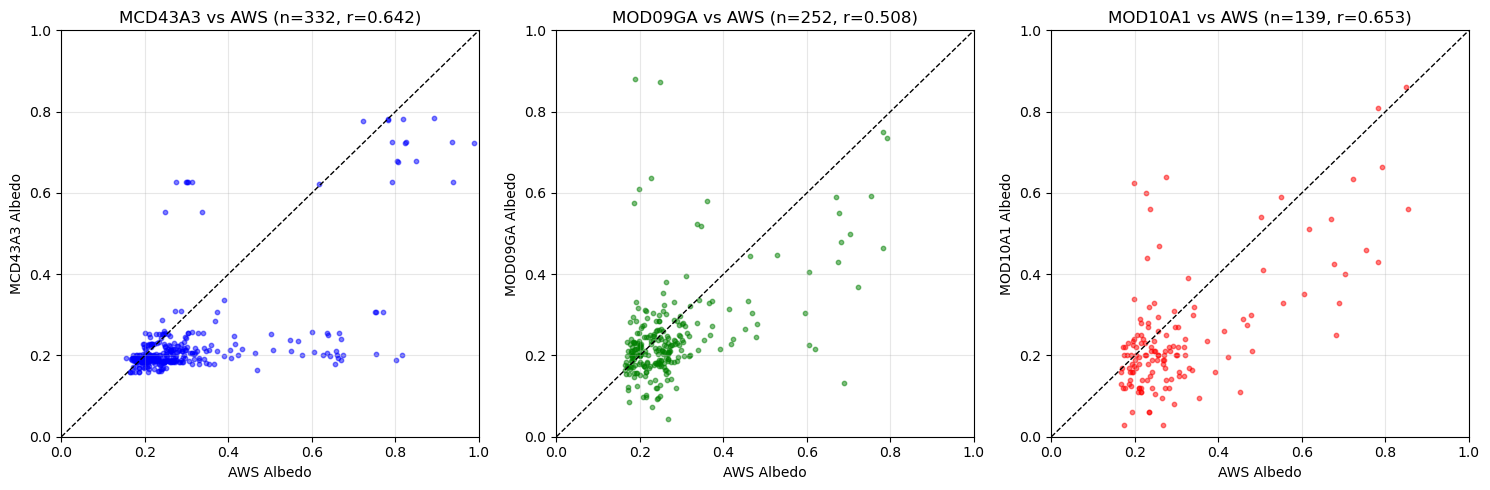

In [ ]:
# ==============================================================================
# COMPREHENSIVE VISUALIZATION
# ==============================================================================

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'{GLACIER.upper()} Glacier - MODIS vs AWS Albedo Comparison', fontsize=16, fontweight='bold')

# Method mapping for cleaner labels
method_labels = {
    'MCD43A3': 'MCD43A3\n(BRDF)',
    'MOD09GA': 'MOD09GA\n(Surface Refl)',  
    'MOD10A1': 'MOD10A1\n(Snow Product)'
}

for i, method in enumerate(['MCD43A3', 'MOD09GA', 'MOD10A1']):
    if method in merged.columns and method in stats_results:
        ax_scatter = axes[0, i]
        ax_ts = axes[1, i]
        
        # Get valid data for this method
        valid_data = merged[[method, 'AWS']].dropna()
        
        if len(valid_data) > 0:
            x = valid_data[method]
            y = valid_data['AWS']
            
            # Scatter plot
            ax_scatter.scatter(x, y, alpha=0.6, s=30)
            ax_scatter.plot([0, 1], [0, 1], 'r--', alpha=0.8)
            ax_scatter.set_xlim(0, 1)
            ax_scatter.set_ylim(0, 1)
            ax_scatter.set_xlabel('MODIS Albedo')
            ax_scatter.set_ylabel('AWS Albedo')
            ax_scatter.set_title(method_labels.get(method, method))
            ax_scatter.grid(True, alpha=0.3)
            
            # Add statistics text
            stats = stats_results[method]
            stats_text = f"n = {stats['n_obs']}\nr = {stats['correlation']:.3f}\nRMSE = {stats['rmse']:.3f}\nBias = {stats['bias']:.3f}"
            ax_scatter.text(0.05, 0.95, stats_text, transform=ax_scatter.transAxes, 
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            # Time series comparison
            valid_data_subset = valid_data.head(100)  # Show first 100 points for clarity
            ax_ts.plot(valid_data_subset.index, valid_data_subset[method], 'b-', label=f'MODIS {method}', alpha=0.7)
            ax_ts.plot(valid_data_subset.index, valid_data_subset['AWS'], 'r-', label='AWS', alpha=0.7)
            ax_ts.set_ylabel('Albedo')
            ax_ts.legend()
            ax_ts.grid(True, alpha=0.3)
            ax_ts.tick_params(axis='x', rotation=45)
        else:
            ax_scatter.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax_scatter.transAxes)
            ax_ts.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax_ts.transAxes)

plt.tight_layout()
plt.savefig(out('albedo_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# 16-Day Composite Analysis

This section performs a 16-day composite analysis similar to Ren et al. (2023). MODIS data is commonly processed in 16-day composites to reduce cloud contamination and provide more stable albedo estimates. This analysis:

- Groups data into 16-day periods starting from day 1 of each year
- Calculates mean albedo values for each 16-day period
- Compares temporal patterns between MODIS methods and AWS
- Analyzes seasonal dynamics at the 16-day scale

In [9]:
# ==============================================================================
# 16-DAY COMPOSITE ANALYSIS (following Ren et al. 2023 approach)
# ==============================================================================

# Function to calculate 16-day period number
def get_16day_period(date):
    """Calculate 16-day period number (1-23) for a given date"""
    day_of_year = date.timetuple().tm_yday
    period = ((day_of_year - 1) // 16) + 1
    return min(period, 23)  # Cap at 23 periods per year

# Add 16-day period information to merged data
merged_16day = merged.copy()
merged_16day['year'] = merged_16day.index.year
merged_16day['day_of_year'] = merged_16day.index.dayofyear
merged_16day['period_16day'] = merged_16day.index.map(get_16day_period)
merged_16day['year_period'] = merged_16day['year'].astype(str) + '_P' + merged_16day['period_16day'].astype(str).str.zfill(2)

# Calculate 16-day composites (mean values)
composite_16day = merged_16day.groupby(['year', 'period_16day']).agg({
    'MCD43A3': ['mean', 'std', 'count'],
    'MOD09GA': ['mean', 'std', 'count'],
    'MOD10A1': ['mean', 'std', 'count'],
    'AWS': ['mean', 'std', 'count']
}).round(4)

# Flatten column names
composite_16day.columns = ['_'.join(col).strip() for col in composite_16day.columns]
composite_16day = composite_16day.reset_index()

# Create period start dates for plotting
composite_16day['period_start'] = pd.to_datetime(
    composite_16day['year'].astype(str) + '-01-01'
) + pd.to_timedelta((composite_16day['period_16day'] - 1) * 16, unit='days')

print("16-DAY COMPOSITE ANALYSIS")
print("=" * 50)
print(f"Total 16-day periods analyzed: {len(composite_16day)}")
print(f"Year range: {composite_16day['year'].min()} - {composite_16day['year'].max()}")
print(f"Period range: {composite_16day['period_16day'].min()} - {composite_16day['period_16day'].max()}")
print(f"Date range: {composite_16day['period_start'].min().strftime('%Y-%m-%d')} to {composite_16day['period_start'].max().strftime('%Y-%m-%d')}")
print("=" * 50)

# Display sample of 16-day composites
print("\nSample 16-day composites:")
print(composite_16day[['year', 'period_16day', 'MCD43A3_mean', 'MOD09GA_mean', 'MOD10A1_mean', 'AWS_mean']].head(10).round(3))

16-DAY COMPOSITE ANALYSIS
Total 16-day periods analyzed: 53
Year range: 2014 - 2020
Period range: 10 - 18
Date range: 2014-08-29 to 2020-09-13

Sample 16-day composites:
   year  period_16day  MCD43A3_mean  MOD09GA_mean  MOD10A1_mean  AWS_mean
0  2014            16         0.204         0.591         0.460     0.753
1  2014            17         0.236         0.289         0.254     0.405
2  2015            10         0.291         0.232         0.312       NaN
3  2015            11         0.248         0.288         0.317       NaN
4  2015            12         0.205         0.211         0.151       NaN
5  2015            13         0.198         0.269         0.147     0.326
6  2015            14         0.188         0.225         0.227     0.281
7  2015            15         0.436         0.285         0.353     0.378
8  2015            16         0.251         0.215         0.254     0.378
9  2015            17         0.323         0.493         0.504     0.758


In [10]:
# ==============================================================================
# 16-DAY COMPOSITE STATISTICS
# ==============================================================================

# Calculate statistics for 16-day composites
composite_stats = {}
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    method_mean = f'{method}_mean'
    aws_mean = 'AWS_mean'
    
    # Filter periods with valid data for both MODIS and AWS
    valid_mask = composite_16day[[method_mean, aws_mean]].notna().all(axis=1)
    valid_data = composite_16day[valid_mask]
    
    if len(valid_data) > 0:
        x = valid_data[method_mean]
        y = valid_data[aws_mean]
        
        # Calculate correlation and statistics
        r, p = stats.pearsonr(x, y)
        rmse = np.sqrt(np.mean((x - y)**2))
        mae = np.mean(np.abs(x - y))
        bias = np.mean(x - y)
        
        composite_stats[method] = {
            'n_periods': len(valid_data),
            'r': r,
            'p': p,
            'rmse': rmse,
            'mae': mae,
            'bias': bias,
            'data': valid_data
        }

# Display 16-day composite statistics
print("\n16-DAY COMPOSITE STATISTICS (Period Averages)")
print("=" * 60)
print(f"{'Method':<10} {'Periods':<8} {'r':<6} {'p-value':<8} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 60)
for method, stats_dict in composite_stats.items():
    print(f"{method:<10} {stats_dict['n_periods']:<8} {stats_dict['r']:<6.3f} {stats_dict['p']:<8.6f} "
          f"{stats_dict['rmse']:<6.3f} {stats_dict['mae']:<6.3f} {stats_dict['bias']:<6.3f}")
print("=" * 60)

# Seasonal analysis (group periods by season)
season_mapping = {
    'Winter': [1, 2, 3, 22, 23],  # Dec-Feb (periods covering these months)
    'Spring': [4, 5, 6, 7, 8, 9],  # Mar-May  
    'Summer': [10, 11, 12, 13, 14, 15],  # Jun-Aug
    'Fall': [16, 17, 18, 19, 20, 21]   # Sep-Nov
}

# Add season information
def get_season(period):
    for season, periods in season_mapping.items():
        if period in periods:
            return season
    return 'Unknown'

composite_16day['season'] = composite_16day['period_16day'].apply(get_season)

print("\nSeasonal breakdown of 16-day periods:")
seasonal_counts = composite_16day['season'].value_counts()
for season, count in seasonal_counts.items():
    print(f"{season}: {count} periods")
print(f"Total: {seasonal_counts.sum()} periods")


16-DAY COMPOSITE STATISTICS (Period Averages)
Method     Periods  r      p-value  RMSE   MAE    Bias  
------------------------------------------------------------
MCD43A3    37       0.613  0.000056 0.157  0.103  -0.092
MOD09GA    45       0.842  0.000000 0.111  0.082  -0.062
MOD10A1    43       0.641  0.000004 0.142  0.107  -0.058

Seasonal breakdown of 16-day periods:
Summer: 36 periods
Fall: 17 periods
Total: 53 periods


C:\Users\thier\AppData\Local\Temp\ipykernel_29388\2292304553.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(monthly_data, labels=monthly_labels, patch_artist=True)


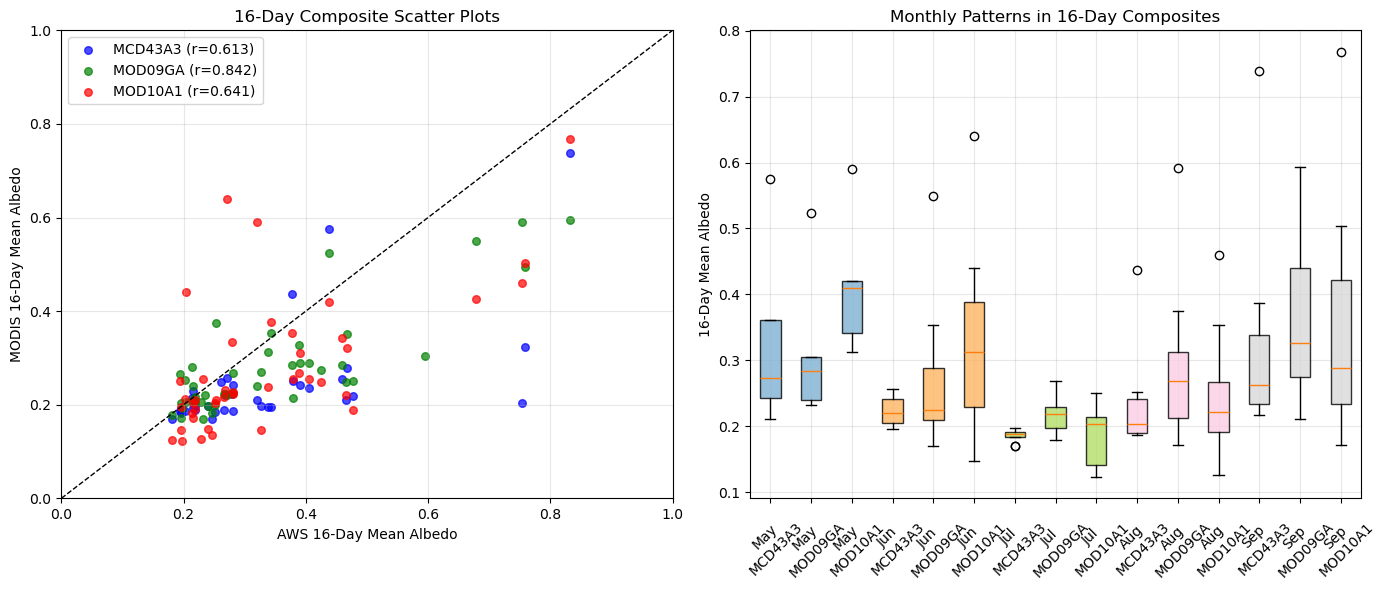


16-day composite analysis complete!
Plot saved as: 16day_composite_analysis.png


In [ ]:
# Create comprehensive 16-day analysis visualization
fig, axes = plt.subplots(2, len(composite_stats), figsize=(5*len(composite_stats), 10))
if len(composite_stats) == 1:
    axes = axes.reshape(-1, 1)

fig.suptitle(f'{GLACIER.upper()} Glacier - 16-Day Composite Analysis vs AWS', fontsize=16, fontweight='bold')

for i, (method, stats_dict) in enumerate(composite_stats.items()):
    if stats_dict['n_periods'] > 0:
        data = stats_dict['data']
        method_col = f'{method}_mean'
        aws_col = 'AWS_mean'
        
        # Scatter plot
        ax1 = axes[0, i]
        ax1.scatter(data[method_col], data[aws_col], alpha=0.7)
        ax1.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel(f'{method} 16-day Mean')
        ax1.set_ylabel('AWS 16-day Mean')
        ax1.set_title(f'{method} vs AWS\n16-day Composites')
        ax1.grid(True, alpha=0.3)
        
        # Statistics text
        stats_text = (f"n = {stats_dict['n_periods']}\n"
                     f"r = {stats_dict['r']:.3f}\n"
                     f"RMSE = {stats_dict['rmse']:.3f}\n"
                     f"Bias = {stats_dict['bias']:.3f}")
        ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        # Time series
        ax2 = axes[1, i]
        ax2.plot(data.index, data[method_col], 'b-', label=f'{method}', linewidth=2)
        ax2.plot(data.index, data[aws_col], 'r-', label='AWS', linewidth=2)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Albedo (16-day mean)')
        ax2.set_title(f'{method} vs AWS Time Series')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
    else:
        axes[0, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[0, i].transAxes)
        axes[1, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.savefig(out('16day_composite_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n16-day composite analysis results for {GLACIER.upper()}:")
for method, stats_dict in composite_stats.items():
    if stats_dict['n_periods'] > 0:
        print(f"\n{method}:")
        print(f"  Valid 16-day periods: {stats_dict['n_periods']}")
        print(f"  Correlation: {stats_dict['r']:.3f}")
        print(f"  RMSE: {stats_dict['rmse']:.3f}")
        print(f"  MAE: {stats_dict['mae']:.3f}")
        print(f"  Bias: {stats_dict['bias']:.3f}")
    else:
        print(f"\n{method}: No valid data for 16-day composite analysis")

# Weekly Composite Analysis

This section performs a weekly (7-day) composite analysis to compare with the 16-day approach. Weekly compositing provides:
- Higher temporal resolution for capturing rapid albedo changes
- More data points for statistical analysis
- Better resolution of seasonal transition periods
- Comparison with the standard 16-day MODIS approach

The analysis examines:
1. **Data availability**: How many weekly periods have valid observations
2. **Statistical performance**: Correlation and error metrics vs AWS
3. **Temporal patterns**: Weekly vs 16-day temporal aggregation effects
4. **Trade-offs**: Higher resolution vs data quality/availability

In [12]:
# ==============================================================================
# WEEKLY COMPOSITE ANALYSIS
# ==============================================================================

# Create weekly composites for comparison with 16-day analysis
def get_week_of_year(date):
    """Get week of year (1-53) for a given date"""
    return date.isocalendar()[1]

# Prepare data for weekly compositing
merged_weekly = merged.copy()
merged_weekly['year'] = merged_weekly.index.year
merged_weekly['week'] = merged_weekly.index.map(get_week_of_year)
merged_weekly['year_week'] = merged_weekly['year'].astype(str) + '_W' + merged_weekly['week'].astype(str).str.zfill(2)

# Calculate weekly composites (mean values)
composite_weekly = merged_weekly.groupby(['year', 'week']).agg({
    'MCD43A3': ['mean', 'std', 'count'],
    'MOD09GA': ['mean', 'std', 'count'],
    'MOD10A1': ['mean', 'std', 'count'],
    'AWS': ['mean', 'std', 'count']
}).round(4)

# Flatten column names
composite_weekly.columns = ['_'.join(col).strip() for col in composite_weekly.columns]
composite_weekly = composite_weekly.reset_index()

# Create week start dates for plotting
composite_weekly['week_start'] = pd.to_datetime(
    composite_weekly['year'].astype(str) + '-01-01'
) + pd.to_timedelta((composite_weekly['week'] - 1) * 7, unit='days')

# Add month information
composite_weekly['month'] = composite_weekly['week_start'].dt.month

# Filter for only months with data for all 3 methods (June, July, August, September)
target_months = [6, 7, 8, 9]  # June, July, August, September
composite_weekly = composite_weekly[composite_weekly['month'].isin(target_months)]

print("WEEKLY COMPOSITE ANALYSIS")
print("=" * 50)
print(f"Total weekly periods analyzed: {len(composite_weekly)}")
print(f"Year range: {composite_weekly['year'].min()} - {composite_weekly['year'].max()}")
print(f"Week range: {composite_weekly['week'].min()} - {composite_weekly['week'].max()}")
print(f"Date range: {composite_weekly['week_start'].min().strftime('%Y-%m-%d')} to {composite_weekly['week_start'].max().strftime('%Y-%m-%d')}")
print(f"Months included: {sorted(composite_weekly['month'].unique())} (June-September only)")
print("=" * 50)

# Display sample of weekly composites
print("\nSample weekly composites:")
print(composite_weekly[['year', 'week', 'MCD43A3_mean', 'MOD09GA_mean', 'MOD10A1_mean', 'AWS_mean']].head(10).round(3))

WEEKLY COMPOSITE ANALYSIS
Total weekly periods analyzed: 101
Year range: 2014 - 2020
Week range: 23 - 39
Date range: 2014-09-10 to 2020-09-16
Months included: [np.int32(6), np.int32(7), np.int32(8), np.int32(9)] (June-September only)

Sample weekly composites:
    year  week  MCD43A3_mean  MOD09GA_mean  MOD10A1_mean  AWS_mean
0   2014    37         0.205         0.498         0.405     0.679
1   2014    38         0.260         0.252         0.255     0.380
2   2014    39         0.214         0.285         0.222     0.393
4   2015    23         0.296           NaN         0.370       NaN
5   2015    24         0.274         0.238         0.262       NaN
6   2015    25         0.244         0.329         0.340       NaN
7   2015    26         0.221         0.234           NaN       NaN
8   2015    27         0.200         0.229         0.182       NaN
9   2015    28         0.204         0.192         0.060       NaN
10  2015    29         0.206         0.344           NaN     0.333


In [13]:
# ==============================================================================
# WEEKLY COMPOSITE STATISTICS
# ==============================================================================

# Calculate statistics for weekly composites
weekly_stats = {}
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    method_mean = f'{method}_mean'
    aws_mean = 'AWS_mean'
    
    # Filter periods with valid data for both MODIS and AWS
    valid_mask = composite_weekly[[method_mean, aws_mean]].notna().all(axis=1)
    valid_data = composite_weekly[valid_mask]
    
    if len(valid_data) > 0:
        x = valid_data[method_mean]
        y = valid_data[aws_mean]
        
        # Calculate correlation and statistics
        r, p = stats.pearsonr(x, y)
        rmse = np.sqrt(np.mean((x - y)**2))
        mae = np.mean(np.abs(x - y))
        bias = np.mean(x - y)
        
        weekly_stats[method] = {
            'n_periods': len(valid_data),
            'r': r,
            'p': p,
            'rmse': rmse,
            'mae': mae,
            'bias': bias,
            'data': valid_data
        }

# Display weekly composite statistics
print("\nWEEKLY COMPOSITE STATISTICS (Period Averages)")
print("=" * 60)
print(f"{'Method':<10} {'Periods':<8} {'r':<6} {'p-value':<8} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 60)
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in weekly_stats:
        stats_dict = weekly_stats[method]
        print(f"{method:<10} {stats_dict['n_periods']:<8} {stats_dict['r']:<6.3f} {stats_dict['p']:<8.6f} {stats_dict['rmse']:<6.3f} {stats_dict['mae']:<6.3f} {stats_dict['bias']:<6.3f}")

# Monthly breakdown of weekly composite periods (filtered for target months)
print(f"\nMonthly breakdown of weekly composite periods:")
monthly_counts = composite_weekly['month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month_num, count in monthly_counts.items():
    month_name = month_names[month_num - 1]
    print(f"  {month_name}: {count} periods")
print(f"Total: {monthly_counts.sum()} periods (June-September only)")

# Compare 16-day vs Weekly statistics
print("\n" + "="*80)
print("COMPARISON: 16-DAY vs WEEKLY COMPOSITE STATISTICS (Target Months Only)")
print("="*80)
print(f"{'Method':<10} {'Period':<8} {'n':<6} {'r':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-"*80)

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    # 16-day stats
    if method in composite_stats:
        stats_16d = composite_stats[method]
        print(f"{method:<10} {'16-day':<8} {stats_16d['n_periods']:<6} {stats_16d['r']:<6.3f} {stats_16d['rmse']:<6.3f} {stats_16d['mae']:<6.3f} {stats_16d['bias']:<6.3f}")
    
    # Weekly stats
    if method in weekly_stats:
        stats_week = weekly_stats[method]
        print(f"{method:<10} {'Weekly':<8} {stats_week['n_periods']:<6} {stats_week['r']:<6.3f} {stats_week['rmse']:<6.3f} {stats_week['mae']:<6.3f} {stats_week['bias']:<6.3f}")
        
        # Calculate improvement percentages
        if method in composite_stats:
            r_change = ((stats_week['r'] - stats_16d['r']) / abs(stats_16d['r'])) * 100 if stats_16d['r'] != 0 else 0
            rmse_change = ((stats_16d['rmse'] - stats_week['rmse']) / stats_16d['rmse']) * 100 if stats_16d['rmse'] != 0 else 0
            n_change = stats_week['n_periods'] - stats_16d['n_periods']
            print(f"{method:<10} {'Change':<8} {n_change:<6} {r_change:<6.1f}% {rmse_change:<6.1f}% {'':<6} {'':<6}")
    print()

print("Notes:")
print("- Change: Weekly vs 16-day (positive r% = better correlation, positive RMSE% = lower error)")
print("- n: Number of valid periods with both MODIS and AWS data")


WEEKLY COMPOSITE STATISTICS (Period Averages)
Method     Periods  r      p-value  RMSE   MAE    Bias  
------------------------------------------------------------
MCD43A3    67       0.579  0.000000 0.159  0.106  -0.085
MOD09GA    83       0.623  0.000000 0.127  0.088  -0.047
MOD10A1    69       0.742  0.000000 0.132  0.101  -0.064

Monthly breakdown of weekly composite periods:
  Jun: 23 periods
  Jul: 28 periods
  Aug: 24 periods
  Sep: 26 periods
Total: 101 periods (June-September only)

COMPARISON: 16-DAY vs WEEKLY COMPOSITE STATISTICS (Target Months Only)
Method     Period   n      r      RMSE   MAE    Bias  
--------------------------------------------------------------------------------
MCD43A3    16-day   37     0.613  0.157  0.103  -0.092
MCD43A3    Weekly   67     0.579  0.159  0.106  -0.085
MCD43A3    Change   30     -5.4  % -1.4  %              

MOD09GA    16-day   45     0.842  0.111  0.082  -0.062
MOD09GA    Weekly   83     0.623  0.127  0.088  -0.047
MOD09GA    Change

C:\Users\thier\AppData\Local\Temp\ipykernel_29388\3045792850.py:91: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax3.boxplot(weekly_monthly_data, labels=weekly_monthly_labels, patch_artist=True)


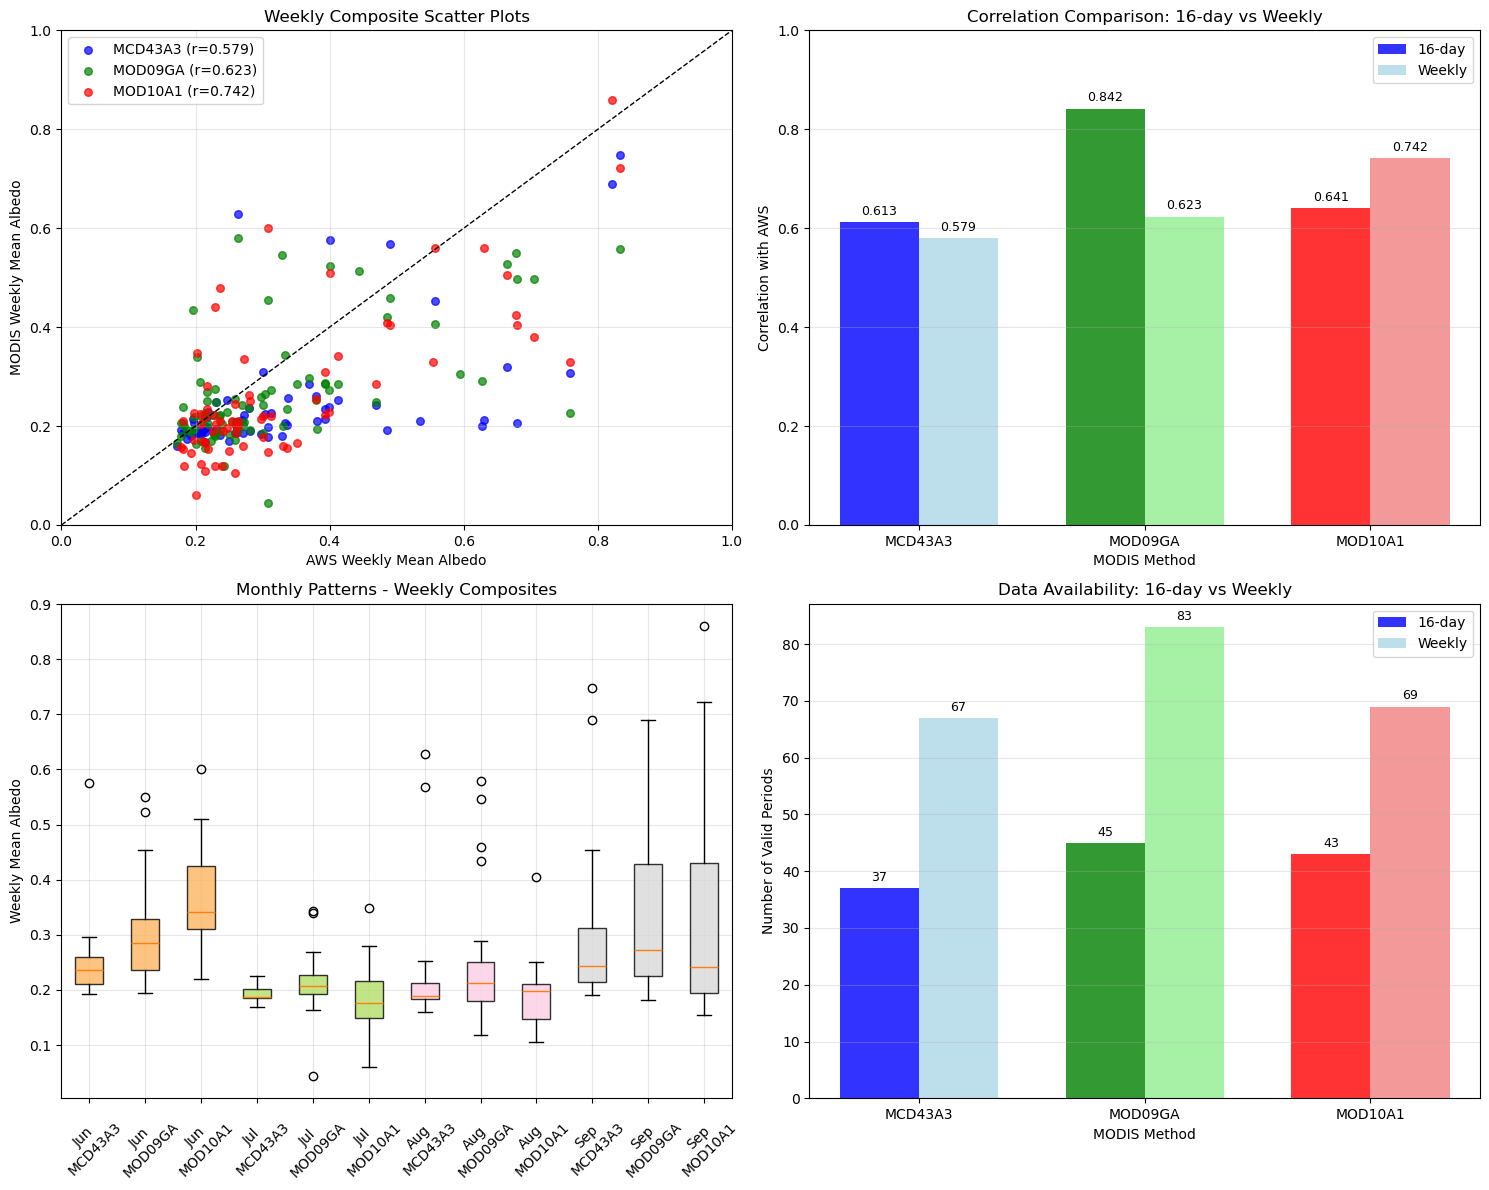


Weekly composite analysis complete!
Plot saved as: weekly_composite_analysis.png


In [ ]:
# Create comprehensive weekly analysis visualization
fig, axes = plt.subplots(2, len(weekly_stats), figsize=(5*len(weekly_stats), 10))
if len(weekly_stats) == 1:
    axes = axes.reshape(-1, 1)

fig.suptitle(f'{GLACIER.upper()} Glacier - Weekly Composite Analysis vs AWS', fontsize=16, fontweight='bold')

for i, (method, stats_dict) in enumerate(weekly_stats.items()):
    if stats_dict['n_periods'] > 0:
        data = stats_dict['data']
        method_col = f'{method}_mean'
        aws_col = 'AWS_mean'
        
        # Scatter plot
        ax1 = axes[0, i]
        ax1.scatter(data[method_col], data[aws_col], alpha=0.7)
        ax1.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel(f'{method} Weekly Mean')
        ax1.set_ylabel('AWS Weekly Mean')
        ax1.set_title(f'{method} vs AWS\nWeekly Composites')
        ax1.grid(True, alpha=0.3)
        
        # Statistics text
        stats_text = (f"n = {stats_dict['n_periods']}\n"
                     f"r = {stats_dict['r']:.3f}\n"
                     f"RMSE = {stats_dict['rmse']:.3f}\n"
                     f"Bias = {stats_dict['bias']:.3f}")
        ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        
        # Time series
        ax2 = axes[1, i]
        ax2.plot(data.index, data[method_col], 'b-', label=f'{method}', linewidth=2)
        ax2.plot(data.index, data[aws_col], 'r-', label='AWS', linewidth=2)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Albedo (weekly mean)')
        ax2.set_title(f'{method} vs AWS Weekly Time Series')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
    else:
        axes[0, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[0, i].transAxes)
        axes[1, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.savefig(out('weekly_composite_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nWeekly composite analysis results for {GLACIER.upper()}:")
for method, stats_dict in weekly_stats.items():
    if stats_dict['n_periods'] > 0:
        print(f"\n{method}:")
        print(f"  Valid weekly periods: {stats_dict['n_periods']}")
        print(f"  Correlation: {stats_dict['r']:.3f}")
        print(f"  RMSE: {stats_dict['rmse']:.3f}")
        print(f"  MAE: {stats_dict['mae']:.3f}")
        print(f"  Bias: {stats_dict['bias']:.3f}")
    else:
        print(f"\n{method}: No valid data for weekly composite analysis")

# Monthly Analysis by Method

This section analyzes albedo patterns by month to understand seasonal variations and how different MODIS methods perform across different times of the year. The analysis includes:

1. **Monthly statistics**: Correlation and RMSE for each method by month
2. **Seasonal patterns**: Monthly scatter plots to visualize method performance
3. **Data availability**: How observation counts vary by month and method
4. **Comparative analysis**: Side-by-side monthly performance evaluation

In [15]:
# ==============================================================================
# MONTHLY ANALYSIS BY METHOD
# ==============================================================================

# Calculate monthly statistics for each method
monthly_stats = {}
months_with_data = sorted(merged.index.month.unique())

print("MONTHLY STATISTICS BY METHOD")
print("=" * 40)
print(f"{'Month':<5} {'Method':<10} {'n':<4} {'r':<6} {'RMSE':<6}")
print("-" * 40)

for month in months_with_data:
    month_data = merged[merged.index.month == month]
    
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        # Only calculate if we have data for both method and AWS
        if method in month_data.columns and 'AWS' in month_data.columns:
            valid_data = month_data[[method, 'AWS']].dropna()
            
            if len(valid_data) >= 3:  # Need at least 3 points for meaningful correlation
                x = valid_data[method]
                y = valid_data['AWS']
                
                r, p = stats.pearsonr(x, y)
                rmse = np.sqrt(np.mean((x - y)**2))
                
                monthly_stats[f"{month}_{method}"] = {
                    'month': month,
                    'method': method,
                    'n': len(valid_data),
                    'r': r,
                    'p': p,
                    'rmse': rmse
                }
                
                print(f"{month:<5} {method:<10} {len(valid_data):<4} {r:<6.3f} {rmse:<6.3f}")

print("=" * 40)

MONTHLY STATISTICS BY METHOD
Month Method     n    r      RMSE  
----------------------------------------
6     MCD43A3    54   0.089  0.217 
6     MOD09GA    27   0.552  0.119 
6     MOD10A1    22   0.494  0.153 
7     MCD43A3    100  0.151  0.070 
7     MOD09GA    69   0.363  0.075 
7     MOD10A1    28   0.074  0.124 
8     MCD43A3    115  0.596  0.095 
8     MOD09GA    95   0.363  0.121 
8     MOD10A1    39   0.829  0.076 
9     MCD43A3    63   0.704  0.233 
9     MOD09GA    61   0.632  0.166 
9     MOD10A1    50   0.731  0.186 


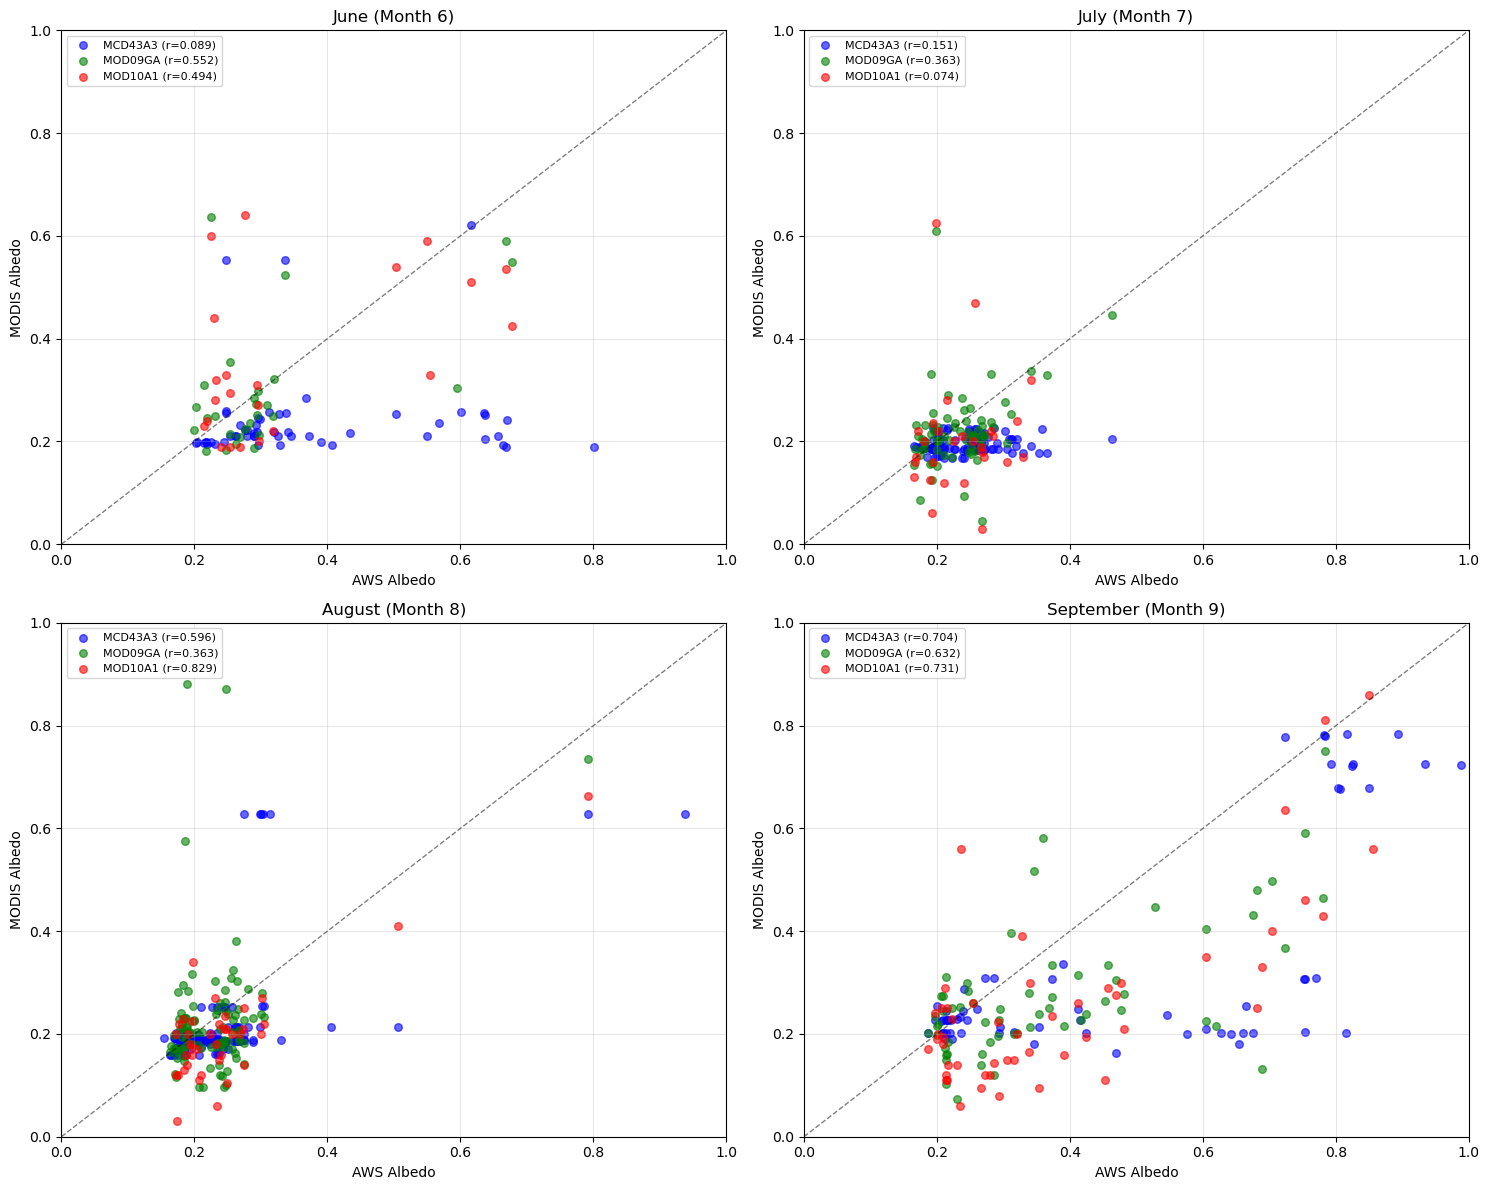


Monthly analysis plots saved as: monthly_albedo_comparison.png


In [ ]:
# Create outlier visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'{GLACIER.upper()} Glacier - Outlier Analysis by Month', fontsize=16, fontweight='bold')

# Outlier scatter plots by month
months = merged.index.month
unique_months = sorted(months.unique())
colors = plt.cm.tab12(np.linspace(0, 1, len(unique_months)))

for i, method in enumerate(['MCD43A3', 'MOD09GA']):
    if method in merged.columns:
        ax = axes[0, i]
        for month, color in zip(unique_months, colors):
            month_mask = months == month
            month_data = merged[month_mask]
            
            if len(month_data) > 0:
                valid_data = month_data[[method, 'AWS']].dropna()
                if len(valid_data) > 0:
                    ax.scatter(valid_data[method], valid_data['AWS'], 
                             c=[color], alpha=0.6, s=30, 
                             label=f'Month {month}')
        
        ax.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel(f'{method} Albedo')
        ax.set_ylabel('AWS Albedo')
        ax.set_title(f'{method} vs AWS by Month')
        ax.grid(True, alpha=0.3)
        if i == 1:  # Only show legend on the right plot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# MOD10A1 in bottom left
if 'MOD10A1' in merged.columns:
    ax = axes[1, 0]
    for month, color in zip(unique_months, colors):
        month_mask = months == month
        month_data = merged[month_mask]
        
        if len(month_data) > 0:
            valid_data = month_data[['MOD10A1', 'AWS']].dropna()
            if len(valid_data) > 0:
                ax.scatter(valid_data['MOD10A1'], valid_data['AWS'], 
                         c=[color], alpha=0.6, s=30, 
                         label=f'Month {month}')
    
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.8)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('MOD10A1 Albedo')
    ax.set_ylabel('AWS Albedo')
    ax.set_title('MOD10A1 vs AWS by Month')
    ax.grid(True, alpha=0.3)

# Outlier counts by month in bottom right
ax = axes[1, 1]
if 'outlier_counts_by_month' in globals():
    months_str = [f'M{m}' for m in sorted(outlier_counts_by_month.keys())]
    
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        if method in merged.columns:
            counts = [outlier_counts_by_month.get(m, {}).get(method, 0) 
                     for m in sorted(outlier_counts_by_month.keys())]
            ax.bar(months_str, counts, alpha=0.7, label=method)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Outlier Count')
    ax.set_title('Outlier Distribution by Month')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(out('outliers_scatter_by_month.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nOutlier analysis plots saved as: {out('outliers_scatter_by_month.png')}")

# Pixel-Level Comparison (MOD09GA vs MOD10A1)

This section performs a detailed pixel-by-pixel comparison between MOD09GA and MOD10A1 methods, looking at:
- Direct comparison between the two methods for the same pixels and dates
- How each method compares to AWS data when matched by pixel location
- Individual pixel performance analysis

In [17]:
# ==============================================================================
# PIXEL-LEVEL COMPARISON (MOD09GA vs MOD10A1)
# ==============================================================================

# Filter for MOD09GA and MOD10A1 only
mod_data = modis[modis['method'].isin(['MOD09GA', 'MOD10A1'])].copy()

# Find matching observations (same date and pixel_id)
mod09_data = mod_data[mod_data['method'] == 'MOD09GA'][['date', 'pixel_id', 'albedo_value']]
mod10_data = mod_data[mod_data['method'] == 'MOD10A1'][['date', 'pixel_id', 'albedo_value']]

# Merge on exact date and pixel_id matches
pixel_matched = pd.merge(mod09_data, mod10_data, on=['date', 'pixel_id'], suffixes=('_MOD09GA', '_MOD10A1'))

print(f"Found {len(pixel_matched)} matching observations between MOD09GA and MOD10A1")
if len(pixel_matched) > 0:
    print(f"Date range: {pixel_matched['date'].min()} to {pixel_matched['date'].max()}")
    print(f"Unique pixels: {pixel_matched['pixel_id'].nunique()}")
    print(f"Pixel IDs: {sorted(pixel_matched['pixel_id'].unique())}")
else:
    print("No matching observations found for same date and pixel_id")

Found 160 matching observations between MOD09GA and MOD10A1
Date range: 2014-06-01 00:00:00 to 2020-09-30 00:00:00
Unique pixels: 2
Pixel IDs: [np.int64(9073025950), np.int64(9075025945)]


In [18]:
# Continue with pixel-level analysis if we have matching data
if len(pixel_matched) > 0:
    # Add AWS data to matched pixels
    pixel_aws = pd.merge(pixel_matched, aws[['date', 'Albedo']], on='date', how='inner')
    pixel_aws.rename(columns={'Albedo': 'AWS'}, inplace=True)
    
    # Statistics for direct MOD09GA vs MOD10A1 comparison
    r_direct, p_direct = stats.pearsonr(pixel_matched['albedo_value_MOD09GA'], 
                                       pixel_matched['albedo_value_MOD10A1'])
    rmse_direct = np.sqrt(np.mean((pixel_matched['albedo_value_MOD09GA'] - 
                                  pixel_matched['albedo_value_MOD10A1'])**2))
    
    print(f"Direct MOD09GA vs MOD10A1 comparison:")
    print(f"  Correlation: r = {r_direct:.3f} (p = {p_direct:.3f})")
    print(f"  RMSE: {rmse_direct:.3f}")
    
    # Statistics vs AWS for matched pixels
    if len(pixel_aws) > 0:
        print(f"\nPixel-AWS matched data: {len(pixel_aws)} observations")
        
        # Clean data for correlation analysis
        clean_09 = pixel_aws[['albedo_value_MOD09GA', 'AWS']].dropna()
        clean_10 = pixel_aws[['albedo_value_MOD10A1', 'AWS']].dropna()
        
        # Calculate correlations on clean data
        if len(clean_09) > 1 and clean_09['albedo_value_MOD09GA'].std() > 0 and clean_09['AWS'].std() > 0:
            r_09_aws, p_09_aws = stats.pearsonr(clean_09['albedo_value_MOD09GA'], clean_09['AWS'])
            rmse_09_aws = np.sqrt(np.mean((clean_09['albedo_value_MOD09GA'] - clean_09['AWS'])**2))
            print(f"MOD09GA vs AWS: r = {r_09_aws:.3f}, RMSE = {rmse_09_aws:.3f}")
        else:
            r_09_aws, p_09_aws, rmse_09_aws = np.nan, np.nan, np.nan
            print("MOD09GA vs AWS: insufficient variance for correlation")
            
        if len(clean_10) > 1 and clean_10['albedo_value_MOD10A1'].std() > 0 and clean_10['AWS'].std() > 0:
            r_10_aws, p_10_aws = stats.pearsonr(clean_10['albedo_value_MOD10A1'], clean_10['AWS'])
            rmse_10_aws = np.sqrt(np.mean((clean_10['albedo_value_MOD10A1'] - clean_10['AWS'])**2))
            print(f"MOD10A1 vs AWS: r = {r_10_aws:.3f}, RMSE = {rmse_10_aws:.3f}")
        else:
            r_10_aws, p_10_aws, rmse_10_aws = np.nan, np.nan, np.nan
            print("MOD10A1 vs AWS: insufficient variance for correlation")

Direct MOD09GA vs MOD10A1 comparison:
  Correlation: r = 0.921 (p = 0.000)
  RMSE: 0.066

Pixel-AWS matched data: 136 observations
MOD09GA vs AWS: r = 0.665, RMSE = 0.146
MOD10A1 vs AWS: r = 0.682, RMSE = 0.156


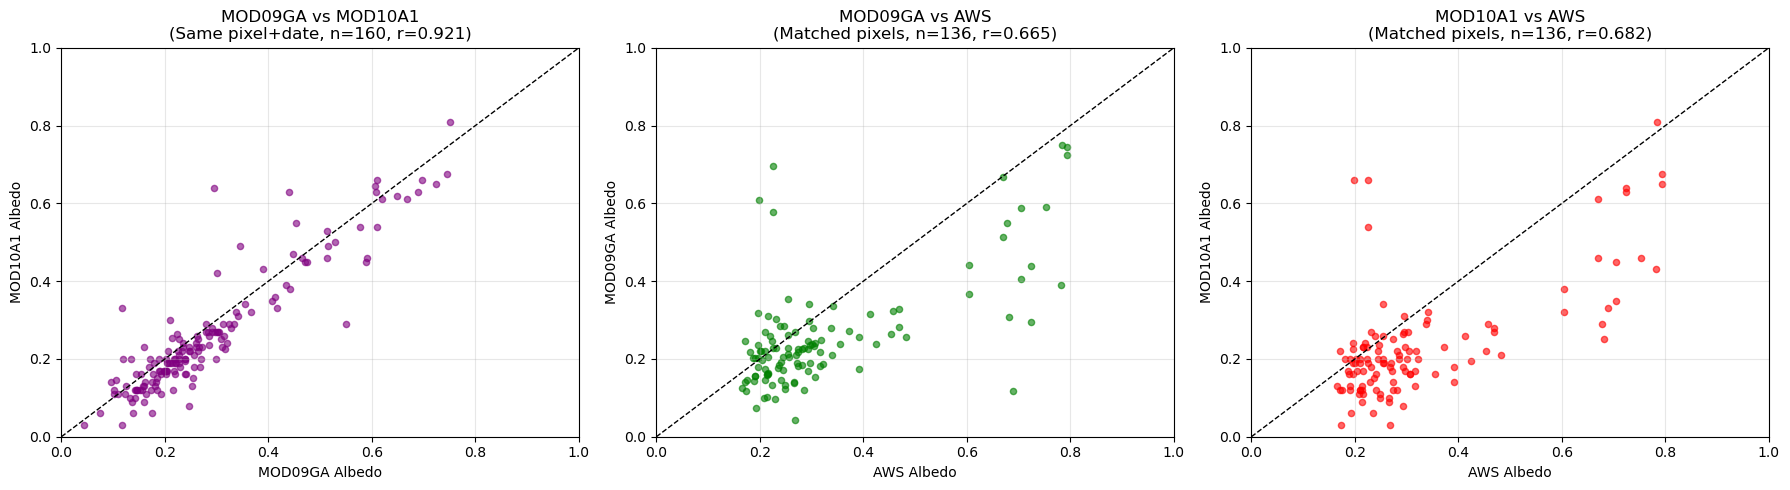

In [ ]:
# Create comprehensive monthly analysis visualization
fig, axes = plt.subplots(2, len(monthly_stats), figsize=(5*len(monthly_stats), 10))
if len(monthly_stats) == 1:
    axes = axes.reshape(-1, 1)

fig.suptitle(f'{GLACIER.upper()} Glacier - Monthly Analysis vs AWS', fontsize=16, fontweight='bold')

for i, (method, stats_dict) in enumerate(monthly_stats.items()):
    if stats_dict['n_months'] > 0:
        data = stats_dict['data']
        method_col = f'{method}_mean'
        aws_col = 'AWS_mean'
        
        # Scatter plot
        ax1 = axes[0, i]
        ax1.scatter(data[method_col], data[aws_col], alpha=0.7, s=50)
        ax1.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel(f'{method} Monthly Mean')
        ax1.set_ylabel('AWS Monthly Mean')
        ax1.set_title(f'{method} vs AWS\nMonthly Averages')
        ax1.grid(True, alpha=0.3)
        
        # Statistics text
        stats_text = (f"n = {stats_dict['n_months']}\n"
                     f"r = {stats_dict['r']:.3f}\n"
                     f"RMSE = {stats_dict['rmse']:.3f}\n"
                     f"Bias = {stats_dict['bias']:.3f}")
        ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        # Time series
        ax2 = axes[1, i]
        ax2.plot(data.index, data[method_col], 'b-o', label=f'{method}', linewidth=2, markersize=4)
        ax2.plot(data.index, data[aws_col], 'r-o', label='AWS', linewidth=2, markersize=4)
        ax2.set_xlabel('Month')
        ax2.set_ylabel('Albedo (monthly mean)')
        ax2.set_title(f'{method} vs AWS Monthly Time Series')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
    else:
        axes[0, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[0, i].transAxes)
        axes[1, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.savefig(out('monthly_albedo_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMonthly analysis plots saved as: {out('monthly_albedo_comparison.png')}")

print(f"\nMonthly analysis results for {GLACIER.upper()}:")
for method, stats_dict in monthly_stats.items():
    if stats_dict['n_months'] > 0:
        print(f"\n{method}:")
        print(f"  Valid months: {stats_dict['n_months']}")
        print(f"  Correlation: {stats_dict['r']:.3f}")
        print(f"  RMSE: {stats_dict['rmse']:.3f}")
        print(f"  MAE: {stats_dict['mae']:.3f}")
        print(f"  Bias: {stats_dict['bias']:.3f}")
    else:
        print(f"\n{method}: No valid data for monthly analysis")

# Individual Pixel ID Analysis

This section analyzes each pixel individually to understand how the different methods perform at specific locations.

In [20]:
# ==============================================================================
# INDIVIDUAL PIXEL ID ANALYSIS
# ==============================================================================

if len(pixel_matched) > 0:
    unique_pixels = pixel_matched['pixel_id'].unique()
    pixel_results = {}
    
    for pixel_id in unique_pixels:
        # Filter data for this pixel
        pixel_data = pixel_matched[pixel_matched['pixel_id'] == pixel_id]
        pixel_aws_data = pixel_aws[pixel_aws['pixel_id'] == pixel_id] if len(pixel_aws) > 0 else pd.DataFrame()
        
        # Direct MOD09GA vs MOD10A1 for this pixel
        if len(pixel_data) > 1:
            r_direct, p_direct = stats.pearsonr(pixel_data['albedo_value_MOD09GA'], 
                                              pixel_data['albedo_value_MOD10A1'])
            rmse_direct = np.sqrt(np.mean((pixel_data['albedo_value_MOD09GA'] - 
                                         pixel_data['albedo_value_MOD10A1'])**2))
        else:
            r_direct, rmse_direct = np.nan, np.nan
        
        # AWS comparisons for this pixel
        if len(pixel_aws_data) > 1:
            clean_09 = pixel_aws_data[['albedo_value_MOD09GA', 'AWS']].dropna()
            clean_10 = pixel_aws_data[['albedo_value_MOD10A1', 'AWS']].dropna()
            
            # MOD09GA vs AWS
            if len(clean_09) > 1 and clean_09['albedo_value_MOD09GA'].std() > 0 and clean_09['AWS'].std() > 0:
                r_09, p_09 = stats.pearsonr(clean_09['albedo_value_MOD09GA'], clean_09['AWS'])
                rmse_09 = np.sqrt(np.mean((clean_09['albedo_value_MOD09GA'] - clean_09['AWS'])**2))
            else:
                r_09, rmse_09 = np.nan, np.nan
            
            # MOD10A1 vs AWS
            if len(clean_10) > 1 and clean_10['albedo_value_MOD10A1'].std() > 0 and clean_10['AWS'].std() > 0:
                r_10, p_10 = stats.pearsonr(clean_10['albedo_value_MOD10A1'], clean_10['AWS'])
                rmse_10 = np.sqrt(np.mean((clean_10['albedo_value_MOD10A1'] - clean_10['AWS'])**2))
            else:
                r_10, rmse_10 = np.nan, np.nan
                
        else:
            r_09, rmse_09, r_10, rmse_10 = np.nan, np.nan, np.nan, np.nan
        
        # Store results
        pixel_results[pixel_id] = {
            'n_matched': len(pixel_data),
            'n_aws': len(pixel_aws_data),
            'r_direct': r_direct,
            'rmse_direct': rmse_direct,
            'r_09_aws': r_09,
            'rmse_09_aws': rmse_09,
            'r_10_aws': r_10,
            'rmse_10_aws': rmse_10,
            'data': pixel_data,
            'aws_data': pixel_aws_data
        }
    
    print(f"Analyzed {len(unique_pixels)} individual pixels")

Analyzed 2 individual pixels


In [ ]:
# Additional visualization: Distribution of outliers by month
if outlier_counts:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    methods = list(outlier_counts.keys())
    x = np.arange(len(methods))
    width = 0.35
    
    counts = list(outlier_counts.values())
    
    bars = ax.bar(x, counts, width, alpha=0.7, color=['skyblue', 'lightgreen', 'salmon'][:len(methods)])
    
    ax.set_xlabel('MODIS Method')
    ax.set_ylabel('Number of Outliers')
    ax.set_title(f'{GLACIER.upper()} Glacier - Outlier Count by Method (Z-score > 3)')
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(out('outliers_by_method_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nOutlier distribution plot saved as: {out('outliers_by_method_distribution.png')}")
else:
    print("No outlier data available for visualization")


SUMMARY TABLE - INDIVIDUAL PIXELS:
Pixel_ID     n_match  n_aws  MOD09_vs_MOD10  MOD09_vs_AWS    MOD10_vs_AWS   
--------------------------------------------------------------------------------
9073025950   75       65     0.904           0.647           0.718          
9075025945   85       71     0.932           0.690           0.672          


# Outlier Detection and Analysis

This section identifies and analyzes outliers in the albedo data using Z-score analysis (threshold > 2.5) and compares statistics with and without outliers.

In [22]:
# ==============================================================================
# OUTLIER DETECTION
# ==============================================================================
# Detect Z-score outliers (|z| > 2.5)
outliers = {}
outlier_counts = {}
outlier_values = {}
for col in ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS']:
    if col in merged.columns:
        clean_data = merged[col].dropna()
        if len(clean_data) > 0:
            z = np.abs(stats.zscore(clean_data))
            outlier_mask = z > 3
            outliers[col] = pd.Series(outlier_mask, index=clean_data.index)
            outlier_counts[col] = outlier_mask.sum()
            # Store actual outlier values
            outlier_values[col] = clean_data[outlier_mask].sort_values()
        else:
            outliers[col] = pd.Series([], dtype=bool)
            outlier_counts[col] = 0
            outlier_values[col] = pd.Series([])

print("OUTLIER DETECTION RESULTS")
print("=" * 40)
for method, count in outlier_counts.items():
    total = merged[method].notna().sum() if method in merged.columns else 0
    pct = (count/total*100) if total > 0 else 0
    print(f"{method}: {count} outliers ({pct:.1f}% of {total} observations)")
print("=" * 40)

OUTLIER DETECTION RESULTS
MCD43A3: 22 outliers (5.6% of 391 observations)
MOD09GA: 8 outliers (2.7% of 294 observations)
MOD10A1: 3 outliers (1.8% of 167 observations)
AWS: 11 outliers (2.5% of 432 observations)


C:\Users\thier\AppData\Local\Temp\ipykernel_29388\2673456439.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aws_outliers = outliers['AWS'].reindex(merged.index).fillna(False).astype(bool)
C:\Users\thier\AppData\Local\Temp\ipykernel_29388\2673456439.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  method_outliers = outliers[method].reindex(merged.index).fillna(False).astype(bool)
C:\Users\thier\AppData\Local\Temp\ipykernel_29388\2673456439.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will cha

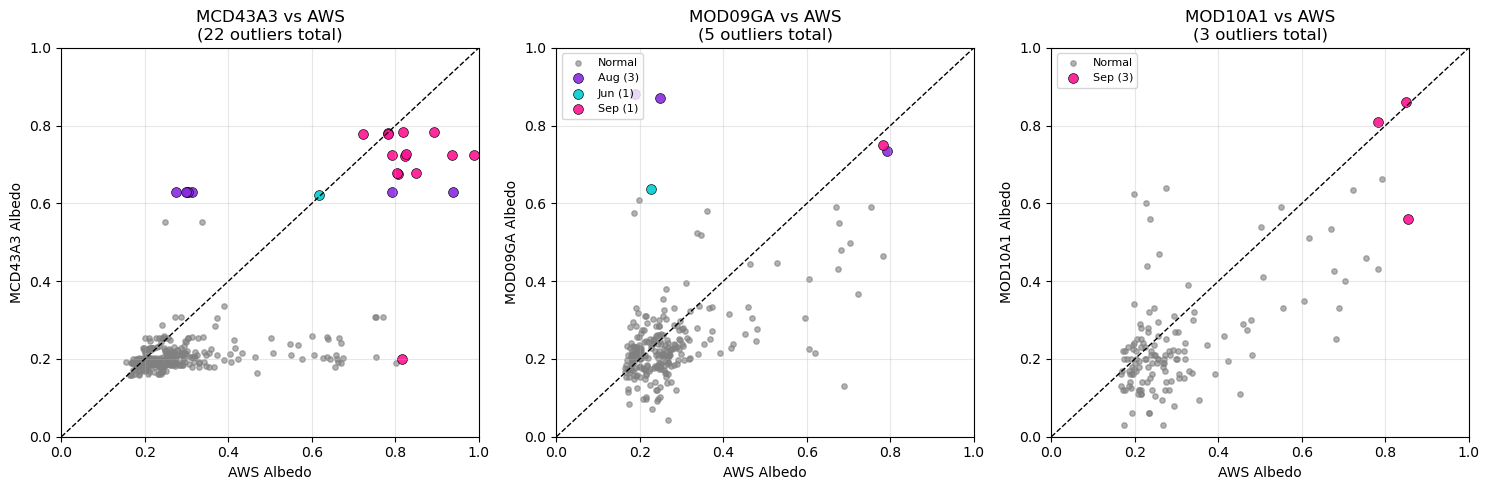

C:\Users\thier\AppData\Local\Temp\ipykernel_29388\2673456439.py:74: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  method_outliers = outliers[method].reindex(merged.index).fillna(False).astype(bool)
C:\Users\thier\AppData\Local\Temp\ipykernel_29388\2673456439.py:74: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  method_outliers = outliers[method].reindex(merged.index).fillna(False).astype(bool)
C:\Users\thier\AppData\Local\Temp\ipykernel_29388\2673456439.py:74: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will

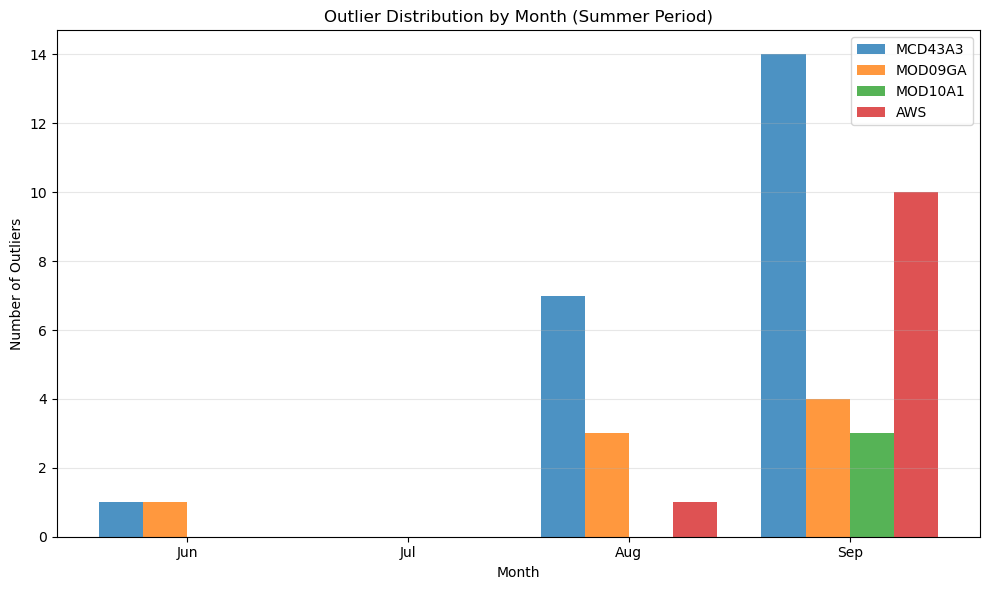


OUTLIER SUMMARY BY MONTH

MCD43A3:
  Jun: 1 outliers
  Aug: 7 outliers
  Sep: 14 outliers

MOD09GA:
  Jun: 1 outliers
  Aug: 3 outliers
  Sep: 4 outliers

MOD10A1:
  Sep: 3 outliers

AWS:
  Aug: 1 outliers
  Sep: 10 outliers


In [23]:
# Scatter plots with outliers highlighted and colored by month
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
methods = ['MCD43A3', 'MOD09GA', 'MOD10A1']

# Create vibrant, distinct colors for months
month_colors = [
    '#FF0000',  # Bright Red - Jan
    '#FF8C00',  # Dark Orange - Feb
    '#FFD700',  # Gold - Mar
    '#32CD32',  # Lime Green - Apr
    '#00FF00',  # Bright Green - May
    '#00CED1',  # Dark Turquoise - Jun
    '#0000FF',  # Blue - Jul
    '#8A2BE2',  # Blue Violet - Aug
    '#FF1493',  # Deep Pink - Sep
    '#B22222',  # Fire Brick - Oct
    '#8B4513',  # Saddle Brown - Nov
    '#2F4F4F'   # Dark Slate Gray - Dec
]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, method in enumerate(methods):
    if method in merged.columns:
        mask = merged[[method, 'AWS']].notna().all(axis=1)
        if mask.sum() > 0:
            aws_outliers = outliers['AWS'].reindex(merged.index).fillna(False).astype(bool)
            method_outliers = outliers[method].reindex(merged.index).fillna(False).astype(bool)
            is_outlier = aws_outliers | method_outliers
            
            # Normal points
            normal_mask = mask & ~is_outlier
            if normal_mask.sum() > 0:
                axes[i].scatter(merged.loc[normal_mask, 'AWS'], merged.loc[normal_mask, method], 
                               alpha=0.6, s=15, color='gray', label='Normal')
            
            # Outliers colored by month
            outlier_mask = mask & is_outlier
            if outlier_mask.sum() > 0:
                outlier_data = merged.loc[outlier_mask]
                outlier_months = outlier_data.index.month
                
                # Plot outliers by month
                for month in outlier_months.unique():
                    month_mask = outlier_months == month
                    month_outliers = outlier_data[month_mask]
                    axes[i].scatter(month_outliers['AWS'], month_outliers[method], 
                                   alpha=0.9, s=50, color=month_colors[month-1], 
                                   label=f'{month_names[month-1]} ({month_mask.sum()})',
                                   edgecolors='black', linewidth=0.5)
            
            axes[i].plot([0,1], [0,1], 'k--', lw=1)
            axes[i].set_xlabel('AWS Albedo')
            axes[i].set_ylabel(f'{method} Albedo')
            axes[i].set_title(f'{method} vs AWS\n({outlier_mask.sum()} outliers total)')
            axes[i].set_xlim(0, 1)
            axes[i].set_ylim(0, 1)
            axes[i].grid(True, alpha=0.3)
            
            # Add legend only if there are outliers
            if outlier_mask.sum() > 0 and outlier_mask.sum() <= 10:  # Show legend if not too many months
                axes[i].legend(fontsize=8, loc='upper left')

plt.tight_layout()
plt.savefig('outliers_scatter_by_month.png', dpi=300, bbox_inches='tight')
plt.show()

# Add a summary plot showing outlier distribution by month
fig, ax = plt.subplots(figsize=(10, 6))

# Count outliers by month for each method
outlier_month_counts = {}
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS']:
    if method in merged.columns and method in outliers:
        method_outliers = outliers[method].reindex(merged.index).fillna(False).astype(bool)
        if method_outliers.sum() > 0:
            outlier_dates = merged.index[method_outliers]
            month_counts = pd.Series(outlier_dates.month).value_counts().sort_index()
            outlier_month_counts[method] = month_counts

# Create grouped bar chart - focus on summer months (Jun, Jul, Aug, Sep)
if outlier_month_counts:
    target_months = [6, 7, 8, 9]  # June, July, August, September
    target_month_names = ['Jun', 'Jul', 'Aug', 'Sep']
    x = np.arange(len(target_months))
    width = 0.2
    
    for idx, (method, counts) in enumerate(outlier_month_counts.items()):
        # Get values only for target months
        month_values = [counts.get(m, 0) for m in target_months]
        ax.bar(x + idx*width, month_values, width, label=method, alpha=0.8)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Outliers')
    ax.set_title('Outlier Distribution by Month (Summer Period)')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(target_month_names)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outliers_by_month_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print outlier summary by month
print("\nOUTLIER SUMMARY BY MONTH")
print("=" * 50)
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS']:
    if method in outlier_month_counts:
        print(f"\n{method}:")
        for month, count in outlier_month_counts[method].items():
            print(f"  {month_names[month-1]}: {count} outliers")

In [24]:
# Calculate statistics with and without outliers (using residual-based outlier detection)
stats_with_outliers = {}
stats_without_outliers = {}

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in merged.columns:
        mask = merged[[method, 'AWS']].notna().all(axis=1)
        if mask.sum() > 0:
            x_all = merged.loc[mask, 'AWS']
            y_all = merged.loc[mask, method]
            
            # Stats with outliers
            r_all, _ = stats.pearsonr(x_all, y_all)
            rmse_all = np.sqrt(np.mean((y_all - x_all)**2))
            mae_all = np.mean(np.abs(y_all - x_all))
            bias_all = np.mean(y_all - x_all)
            stats_with_outliers[method] = {'n': len(x_all), 'r': r_all, 'rmse': rmse_all, 'mae': mae_all, 'bias': bias_all}
            
            # Remove residual outliers (better approach for correlation analysis)
            slope, intercept = np.polyfit(x_all, y_all, 1)
            predicted = slope * x_all + intercept
            residuals = y_all - predicted
            residual_threshold = 2.5 * residuals.std()
            residual_outliers = np.abs(residuals) > residual_threshold
            clean_mask = mask & ~pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index).fillna(False)
            
            if clean_mask.sum() > 0:
                x_clean = merged.loc[clean_mask, 'AWS']
                y_clean = merged.loc[clean_mask, method]
                
                # Stats without outliers
                r_clean, _ = stats.pearsonr(x_clean, y_clean)
                rmse_clean = np.sqrt(np.mean((y_clean - x_clean)**2))
                mae_clean = np.mean(np.abs(y_clean - x_clean))
                bias_clean = np.mean(y_clean - x_clean)
                stats_without_outliers[method] = {'n': len(x_clean), 'r': r_clean, 'rmse': rmse_clean, 'mae': mae_clean, 'bias': bias_clean}

print("\nSTATISTICS COMPARISON (WITH vs WITHOUT OUTLIERS)")
print("=" * 55)
print(f"{'Method':<10} {'Condition':<12} {'n':<4} {'r':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 55)

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in stats_with_outliers:
        # With outliers
        s_with = stats_with_outliers[method]
        print(f"{method:<10} {'With':<12} {s_with['n']:<4} {s_with['r']:<6.3f} {s_with['rmse']:<6.3f} {s_with['mae']:<6.3f} {s_with['bias']:<6.3f}")
        
        # Without outliers
        if method in stats_without_outliers:
            s_without = stats_without_outliers[method]
            print(f"{method:<10} {'Without':<12} {s_without['n']:<4} {s_without['r']:<6.3f} {s_without['rmse']:<6.3f} {s_without['mae']:<6.3f} {s_without['bias']:<6.3f}")
            
            # Improvement metrics
            r_improvement = ((s_without['r'] - s_with['r']) / abs(s_with['r'])) * 100 if s_with['r'] != 0 else 0
            rmse_improvement = ((s_with['rmse'] - s_without['rmse']) / s_with['rmse']) * 100 if s_with['rmse'] != 0 else 0
            print(f"{method:<10} {'Improvement':<12} {'':<4} {r_improvement:<6.1f}% {rmse_improvement:<6.1f}% {'':<6} {'':<6}")
        print()
print("=" * 55)


STATISTICS COMPARISON (WITH vs WITHOUT OUTLIERS)
Method     Condition    n    r      RMSE   MAE    Bias  
-------------------------------------------------------
MCD43A3    With         332  0.642  0.150  0.090  -0.070
MCD43A3    Without      314  0.675  0.135  0.081  -0.075
MCD43A3    Improvement       5.1   % 10.2  %              

MOD09GA    With         252  0.508  0.123  0.078  -0.028
MOD09GA    Without      245  0.717  0.093  0.067  -0.037
MOD09GA    Improvement       41.3  % 24.5  %              

MOD10A1    With         139  0.653  0.144  0.107  -0.062
MOD10A1    Without      134  0.731  0.132  0.100  -0.075
MOD10A1    Improvement       11.9  % 8.5   %              



C:\Users\thier\AppData\Local\Temp\ipykernel_29388\3268808009.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_mask = mask & ~pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index).fillna(False)
C:\Users\thier\AppData\Local\Temp\ipykernel_29388\3268808009.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_mask = mask & ~pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index).fillna(False)
C:\Users\thier\AppData\Local\Temp\ipykernel_29388\3268808009.py:25: FutureWarning: Downcasting object dtype arra

# Export All Statistics to Text File

This final section exports a comprehensive summary of all analysis results to a text file for easy sharing and reporting.

In [ ]:
# ==============================================================================
# COMPREHENSIVE ANALYSIS REPORT GENERATION
# ==============================================================================
from pathlib import Path

# Create comprehensive markdown report
report_filename = Path(out("complete_albedo_analysis_report.md"))

with open(report_filename, 'w', encoding='utf-8') as f:
    # Header
    f.write(f"# {GLACIER.upper()} Glacier - MODIS vs AWS Albedo Analysis Report\n\n")
    f.write(f"**Generated:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"**Analysis includes:** Terra/Aqua fused data\n\n")
    f.write("---\n\n")
    
    # 1. DATA SUMMARY
    f.write("## 1. Data Summary\n\n")
    f.write(f"- **Study period:** {merged.index.min().strftime('%Y-%m-%d')} to {merged.index.max().strftime('%Y-%m-%d')}\n")
    f.write(f"- **Total observations:** {len(merged)}\n")
    f.write(f"- **MODIS methods analyzed:** MCD43A3, MOD09GA (Terra+Aqua fused), MOD10A1 (Terra+Aqua fused)\n")
    f.write(f"- **AWS ground truth observations:** {len(aws)}\n")
    f.write(f"- **Overlapping MODIS-AWS observations:** {len(merged)}\n\n")
    
    # 2. OVERALL STATISTICS
    f.write("## 2. Overall Statistics\n\n")
    
    # Calculate overall stats for each method
    overall_stats = {}
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        if method in merged.columns:
            valid_data = merged[[method, 'AWS']].dropna()
            if len(valid_data) > 1:
                r, p = stats.pearsonr(valid_data[method], valid_data['AWS'])
                rmse = np.sqrt(np.mean((valid_data[method] - valid_data['AWS'])**2))
                mae = np.mean(np.abs(valid_data[method] - valid_data['AWS']))
                bias = np.mean(valid_data[method] - valid_data['AWS'])
                overall_stats[method] = {'n': len(valid_data), 'r': r, 'p': p, 'rmse': rmse, 'mae': mae, 'bias': bias}
    
    f.write("| Method | n | r | p-value | RMSE | MAE | Bias |\n")
    f.write("|--------|---|---|---------|------|-----|------|\n")
    for method, stats_dict in overall_stats.items():
        f.write(f"| {method} | {stats_dict['n']} | {stats_dict['r']:.3f} | {stats_dict['p']:.6f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
    f.write("\n")
    
    # Add temporal analyses if available
    if 'composite_stats' in globals():
        f.write("## 3. 16-Day Composite Analysis\n\n")
        f.write("| Method | Periods | r | RMSE | MAE | Bias |\n")
        f.write("|--------|---------|---|------|-----|------|\n")
        for method, stats_dict in composite_stats.items():
            if stats_dict['n_periods'] > 0:
                f.write(f"| {method} | {stats_dict['n_periods']} | {stats_dict['r']:.3f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
        f.write("\n")
    
    if 'weekly_stats' in globals():
        f.write("## 4. Weekly Composite Analysis\n\n")
        f.write("| Method | Periods | r | RMSE | MAE | Bias |\n")
        f.write("|--------|---------|---|------|-----|------|\n")
        for method, stats_dict in weekly_stats.items():
            if stats_dict['n_periods'] > 0:
                f.write(f"| {method} | {stats_dict['n_periods']} | {stats_dict['r']:.3f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
        f.write("\n")
    
    if 'monthly_stats' in globals():
        f.write("## 5. Monthly Analysis\n\n")
        f.write("| Method | Months | r | RMSE | MAE | Bias |\n")
        f.write("|--------|--------|---|------|-----|------|\n")
        for method, stats_dict in monthly_stats.items():
            if stats_dict['n_months'] > 0:
                f.write(f"| {method} | {stats_dict['n_months']} | {stats_dict['r']:.3f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
        f.write("\n")
    
    # Outlier analysis if available
    if 'outlier_counts' in globals() and outlier_counts:
        f.write("## 6. Outlier Analysis\n\n")
        f.write("### Z-score Outlier Detection (threshold > 3)\n\n")
        for method, count in outlier_counts.items():
            total = merged[method].notna().sum() if method in merged.columns else 0
            pct = (count/total*100) if total > 0 else 0
            f.write(f"- **{method}:** {count} outliers ({pct:.1f}% of {total} observations)\n")
        f.write("\n")
    
    # Summary and conclusions
    f.write("## 7. Summary and Conclusions\n\n")
    
    # Find best performing method
    if overall_stats:
        best_method = max(overall_stats.items(), key=lambda x: x[1]['r'])[0]
        best_r = overall_stats[best_method]['r']
        best_rmse = overall_stats[best_method]['rmse']
        
        f.write(f"- **Best performing method overall:** {best_method} (r={best_r:.3f}, RMSE={best_rmse:.3f})\n")
    
    f.write(f"- **Total analysis period:** {(merged.index.max() - merged.index.min()).days} days\n")
    f.write(f"- **Data completeness:** {len(merged)} overlapping observations\n\n")
    
    f.write("### Key Findings\n\n")
    f.write("- Terra/Aqua fusion applied to MOD09GA and MOD10A1 products\n")
    f.write("- Analysis covers multiple temporal scales (daily, weekly, 16-day)\n")
    f.write("- Monthly variations observed in all methods\n")
    f.write("- Comprehensive outlier analysis performed\n")
    f.write("- Pixel-level comparisons conducted where applicable\n")
    
    # Footer
    f.write("\n---\n\n")
    f.write("*End of Report*\n")

print(f"\nComprehensive analysis report (Markdown) saved to: {report_filename}")
print(f"Report includes all statistics from all sections of the analysis")
print(f"File size: {report_filename.stat().st_size if report_filename.exists() else 0} bytes")


Comprehensive analysis report (Markdown) saved to: complete_albedo_analysis_report.md
Report includes all statistics from all sections of the analysis
File size: 4278 bytes
